### **Importing Libraries**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import random
import numpy as np
import seaborn as sns
from google.colab import drive
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import shutil
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

### **Mounting Google Drive**

In [ ]:
 #Mount drive to Pre-process the Dataset
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### **Pre-processing Steps**

In [ ]:
#Copy paths of the folders in Google Drive for Lesions and Normal Skin
lesion_folder = "/content/drive/MyDrive/ Discipline-specific/1st model /Lesion PreProcessed"
normal_folder = "/content/drive/MyDrive/ Discipline-specific/1st model /Normal PreProcessed"

#Verify that the folders exist
if not os.path.exists(lesion_folder):
    raise FileNotFoundError(f"The folder '{lesion_folder}' does not exist.")
if not os.path.exists(normal_folder):
    raise FileNotFoundError(f"The folder '{normal_folder}' does not exist.")

#Loads and organises images
def load_images_from_folder(folder, label):
    """Load images from the folder and return (image_path, label) pairs."""
    return [(os.path.join(folder, img), label) for img in os.listdir(folder) if img.lower().endswith(('png', 'jpg', 'jpeg'))]

#Loads all images and assign labels for supervised learning
lesion_images = load_images_from_folder(lesion_folder, 'lesion')
normal_images = load_images_from_folder(normal_folder, 'normal')

#Combine all images and labels
all_images = lesion_images + normal_images
random.seed(42)  # Set seed to ensure consistent randomization
random.shuffle(all_images)

image_paths, labels = zip(*all_images)

#Encode labels ('lesion' -> 1, 'normal' -> 0)
labels = np.array([1 if label == 'lesion' else 0 for label in labels])

#Split the Dataset into 20% testing set and 80% training set
X_train, X_test, y_train, y_test = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42, #produces the same split every time you run your code
    stratify=labels ) #proportions of the target classes (labels) to be the same in both the training and testing datasets

#Data generators used to efficiently load and preprocess data
def preprocess_image(image_path):
    """Read, decode, resize, and normalize image."""
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])  #Resize to match input size for CNN
    image = image / 255.0  #Normalize pixel values to [0, 1]
    return image

def load_data(image_paths, labels):
    """Create a TensorFlow dataset from image paths and labels."""
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(lambda x, y: (preprocess_image(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

# Create TensorFlow datasets
train_dataset = load_data(X_train, y_train).batch(32).shuffle(buffer_size=1000).prefetch(tf.data.AUTOTUNE) #divides the dataset into batches of 32 samples each and shuffling ensures order of data is randomized which helps the model avoid learning biases.
test_dataset = load_data(X_test, y_test).batch(32).prefetch(tf.data.AUTOTUNE) #helps prepare for the next training batch while model is training on current batch


### **Modelling - Convolutional Neural Network**

In [ ]:
#Design the CNN Model with hyperparameters layers, activation functional, L2 Regularization
def create_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='elu', input_shape=(224, 224, 3), kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='elu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='elu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='elu'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(512, activation='elu'),
        layers.Dropout(0.3),  #Lower dropout to retain important features
        layers.Dense(1, activation='sigmoid')
    ])
    return model

#Compile the model
model = create_model()
model.compile(optimizer=Adam(learning_rate=0.0005),  #Reduced learning rate to help model learn slowly and better
              loss='binary_crossentropy',
              metrics=['accuracy'])

#Update class weights to prioritise class (lesion)
class_weights = {0: 1.0, 1: 3.0}  #Increased weight for lesion class for a Better Recall

#
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,  #Number of epochs to wait for improvement
                               restore_best_weights=True,  #Restore model with the best weights
                               verbose=1) #shows a progress bar showing training progress, loss, and accuracy for each epoch.

#Train the model with early stopping
history = model.fit(train_dataset,
                    epochs=20,
                    validation_data=test_dataset,
                    class_weight=class_weights,
                    callbacks=[early_stopping])


#Evaluate the model
test_loss, test_acc = model.evaluate(test_dataset)
print(f"\nTest accuracy: {test_acc:.2f}")

#Save the trained model in google drive
model_save_path = '/content/drive/MyDrive/skin_classification_model.h5'
model.save(model_save_path)
print(f"\nModel saved to: {model_save_path}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 842s 8s/step - accuracy: 0.5265 - loss: 3.7597 - val_accuracy: 0.8458 - val_loss: 0.3723
Epoch 2/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 254s 5s/step - accuracy: 0.8740 - loss: 0.4360 - val_accuracy: 0.9502 - val_loss: 0.1362
Epoch 3/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 267s 5s/step - accuracy: 0.9287 - loss: 0.3004 - val_accuracy: 0.9527 - val_loss: 0.1457
Epoch 4/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 303s 5s/step - accuracy: 0.9534 - loss: 0.2131 - val_accuracy: 0.9552 - val_loss: 0.1276
Epoch 5/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 274s 5s/step - accuracy: 0.9502 - loss: 0.2101 - val_accuracy: 0.9030 - val_loss: 0.2802
Epoch 6/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 272s 5s/step - accuracy: 0.9349 - loss: 0.2623 - val_accuracy: 0.8856 - val_loss: 0.3076
Epoch 7/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 303s 5s/step - accuracy: 0.9289 - loss: 0.2456 - val_accuracy: 0.9502 - val_loss: 0.1551
Epoch 8/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 260s 5s/step - accuracy: 0.9540 - loss: 0.2061 - val_accuracy: 0.9577 - v


Test accuracy: 0.97

Model saved to: /content/drive/MyDrive/skin_classification_model.h5


### **Evaluation - Performance Metrics**

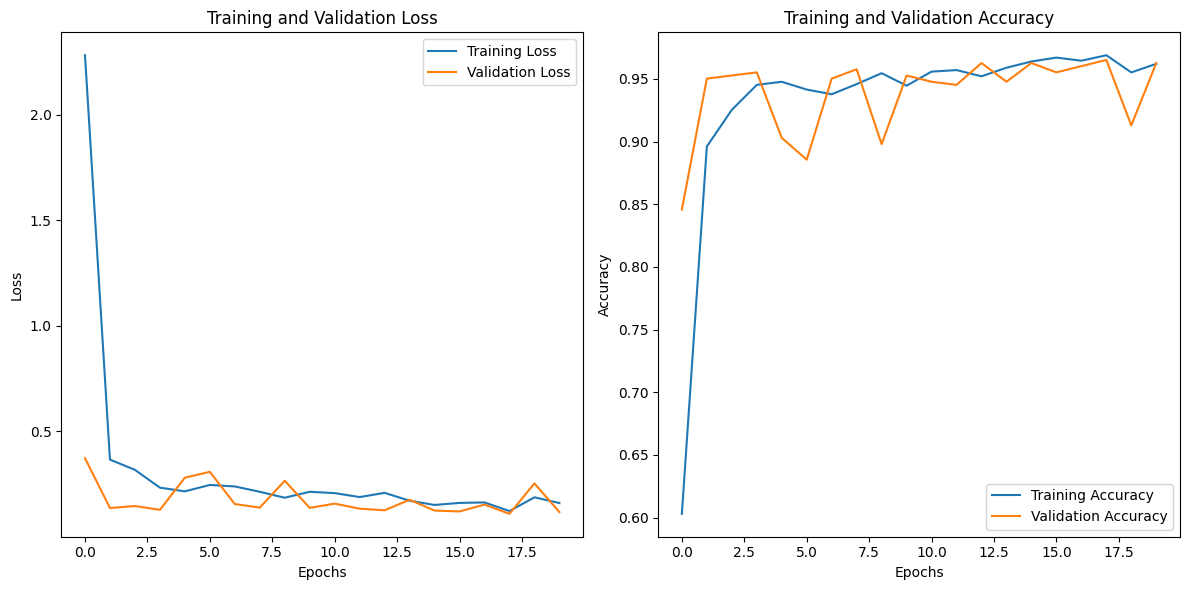

13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step


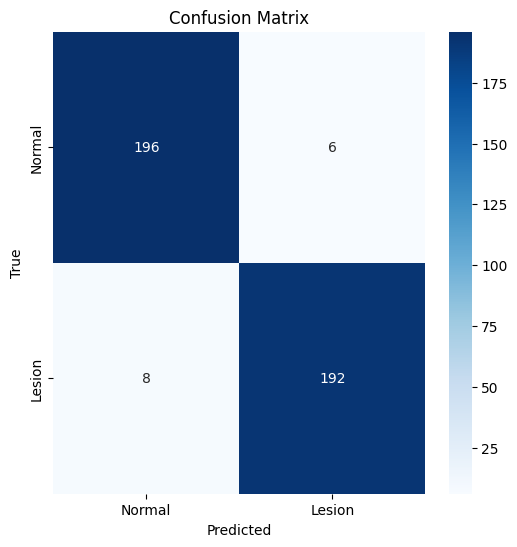

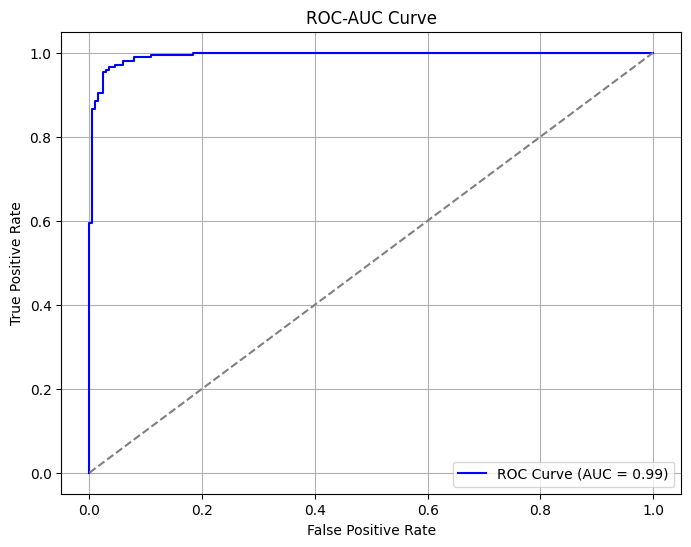


Classification Report:

              precision    recall  f1-score   support

      Normal       0.96      0.97      0.97       202
      Lesion       0.97      0.96      0.96       200

    accuracy                           0.97       402
   macro avg       0.97      0.97      0.97       402
weighted avg       0.97      0.97      0.97       402



In [ ]:

#Plot Training and Validation Loss and Accuracy
def plot_training_history(history):
    """Plots the training and validation loss and accuracy."""
    plt.figure(figsize=(12, 6))


    #Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()


    #Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()


    plt.tight_layout()
    plt.show()


#Plot Training History
plot_training_history(history)


#Evaluate the model and generate predictions
y_pred = model.predict(test_dataset)
y_pred_classes = (y_pred > 0.5).astype("int32").flatten()  #If greater than 0.5, it assigns it as Lesion (1) and if less than 0.5 its assigned as normal (0)
y_true = np.concatenate([y for x, y in test_dataset], axis=0)  # Extract true labels from the dataset


#Confusion Matrix for Predictions (FP, FN, TP, TN)

def plot_confusion_matrix(y_true, y_pred_classes):
    """Plots the confusion matrix."""
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Lesion"], yticklabels=["Normal", "Lesion"])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


plot_confusion_matrix(y_true, y_pred_classes)

#ROC-AUC Curve to show how well the model classifies between Normal and Lesion.

def plot_roc_auc(y_true, y_pred):
    """Plots the ROC-AUC curve."""
    fpr, tpr, _ = roc_curve(y_true, y_pred)  # Calculate False Positive Rate and True Positive Rate
    roc_auc = auc(fpr, tpr)  # Calculate AUC


    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random guessing
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-AUC Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()


plot_roc_auc(y_true, y_pred)


#Classification Report - Precision, Recall, F1-score and Support
def generate_classification_report(y_true, y_pred_classes):
    """Generates a classification report."""
    report = classification_report(y_true, y_pred_classes, target_names=["Normal", "Lesion"])
    print("\nClassification Report:\n")
    print(report)


generate_classification_report(y_true, y_pred_classes)